# **Random Entry Trading Strategy (Backtesting with Python)**

---

## **1. Overview**
In this notebook, we explore a **random-entry trading strategy** tested over **7 years of historical data** on **14 stocks**. The strategy's performance is based on **risk management** and **exit strategy** rather than predictive market signals.

### **Key Points:**
- Entry direction (long/short) is chosen randomly.
- Stop-loss levels are set based on **N times the Average True Range (ATR)**.
- **Trailing stop-losses** follow the price to lock in profits.
- No take-profit is used—only trailing stops.
- Achieved **160% returns** over the backtesting period.

---

## **2. Concept of Random Entry Strategy**
- Introduced by **Tom Basso**, a hedge fund manager.
- Key principle: Profits come from **managing exits and risk**, not predicting market directions.
- Even random entries can be profitable if:
  - Winning trades **run long enough**.
  - Losing trades are **cut early**.

---

## **3. Python Code Walkthrough**

### **3.1 Import Libraries and Read Data**
```python



In [1]:
# Import necessary libraries
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm # for progress bar
import os
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
tqdm.pandas() 

# Read csv to dataframe
def read_csv_to_dataframe(file_path):
    df = pd.read_csv(file_path)
    df["Gmt time"] = df["Gmt time"].str.replace(".000", "") #the data is daily, we'll remove the demisecond
    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S')
    df = df[df.High != df.Low] #remove rows where high and low are the same,: weekends or holidays
    df.set_index("Gmt time", inplace=True) # 
    return df

# Read data folder
def read_data_folder(folder_path="./files/data_stocks/"):
    dataframes = []
    file_names = []
    #iterating over the files with tqdm givingthe progress bar
    for file_name in tqdm(os.listdir(folder_path)):# 
        if file_name.endswith('.csv'):
            # construct the full path to the current file
            file_path = os.path.join(folder_path, file_name) 
            #read the file
            df = read_csv_to_dataframe(file_path)
            dataframes.append(df)
            file_names.append(file_name)
    return dataframes, file_names


# we are generating random buy and sell strategy
def total_signal(df, current_candle):
    return np.random.choice([1, 2]) # 1 for short 2 for long
#--- To do: modify choice to favour market trend.

# we apply the total signal function to the dataframe
def add_total_signal(df):
    #
    df['TotalSignal'] = df.progress_apply(lambda row: total_signal(df, row.name), axis=1) #  axis=1 row,  0 for column
    return df

# we add the ATR f to the dataframe
ATR_length=10
def add_atr(df, length=ATR_length):
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length)
    return df


# let's identify the support and resistance points
def add_pointpos_column(df, signal_column):
    """
    Adds a 'pointpos' column to the DataFrame to indicate the position of support and resistance points.
    
    Parameters:
    df (DataFrame): DataFrame containing the stock data with the specified SR column, 'Low', and 'High' columns.
    sr_column (str): The name of the column to consider for the SR (support/resistance) points.
    
    Returns:
    DataFrame: The original DataFrame with an additional 'pointpos' column.
    """
    def pointpos(row):
        if row[signal_column] == 2:
            return row['Low'] - 1e-4
        elif row[signal_column] == 1:
            return row['High'] + 1e-4
        else:
            return np.nan

    df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
    return df



# let's plot the candlestick with the support and resistance points
def plot_candlestick_with_signals(df, start_index, num_rows):
    """
    Plots a candlestick chart with signal points.
    
    Parameters:
    df (DataFrame): DataFrame containing the stock data with 'Open', 'High', 'Low', 'Close', and 'pointpos' columns.
    start_index (int): The starting index for the subset of data to plot.
    num_rows (int): The number of rows of data to plot.
    
    Returns:
    None
    """
    df_subset = df[start_index:start_index + num_rows]
    
    fig = make_subplots(rows=1, cols=1)
    # candlestick
    fig.add_trace(go.Candlestick(x=df_subset.index,
                                 open=df_subset['Open'],
                                 high=df_subset['High'],
                                 low=df_subset['Low'],
                                 close=df_subset['Close'],
                                 name='Candlesticks'),
                  row=1, col=1)
    # entry points/exit points, level points
    fig.add_trace(go.Scatter(x=df_subset.index, y=df_subset['pointpos'], mode="markers",
                             marker=dict(size=10, color="MediumPurple", symbol='circle'),
                             name="Entry Points"),
                  row=1, col=1)
    # plot layout
    fig.update_layout(
        width=1200, 
        height=800, 
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        showlegend=True,
        legend=dict(
            x=0.01,
            y=0.99,
            traceorder="normal",
            font=dict(
                family="sans-serif",
                size=12,
                color="white"
            ),
            bgcolor="black",
            bordercolor="gray",
            borderwidth=2
        )
    )
    
    fig.show()



In [ ]:
folder_path = "./files/data_stocks"
dataframes, file_names = read_data_folder(folder_path)

for i, df in enumerate(dataframes):
    print("working on dataframe ", i, "...")
    df = add_atr(df, length=ATR_length)
    df = add_total_signal(df)
    df = add_pointpos_column(df, "TotalSignal")
    df.dropna(inplace=True)
    dataframes[i] = df  # Update the dataframe in the list
    

100%|██████████| 14/14 [00:00<00:00, 53.69it/s]


working on dataframe  0 ...


100%|██████████| 1854/1854 [00:00<00:00, 63871.08it/s]


working on dataframe  1 ...


100%|██████████| 1854/1854 [00:00<00:00, 65457.66it/s]


working on dataframe  2 ...


100%|██████████| 521/521 [00:00<00:00, 46355.24it/s]


working on dataframe  3 ...


100%|██████████| 1781/1781 [00:00<00:00, 57975.27it/s]


working on dataframe  4 ...


100%|██████████| 1854/1854 [00:00<00:00, 81993.25it/s]


working on dataframe  5 ...


100%|██████████| 1659/1659 [00:00<00:00, 66104.43it/s]


working on dataframe  6 ...


100%|██████████| 1781/1781 [00:00<00:00, 47484.10it/s]


working on dataframe  7 ...


100%|██████████| 1781/1781 [00:00<00:00, 56495.03it/s]


working on dataframe  8 ...


100%|██████████| 1781/1781 [00:00<00:00, 51476.80it/s]


working on dataframe  9 ...


100%|██████████| 1872/1872 [00:00<00:00, 66295.19it/s]


working on dataframe  10 ...


100%|██████████| 1598/1598 [00:00<00:00, 67057.17it/s]


working on dataframe  11 ...


100%|██████████| 1857/1857 [00:00<00:00, 53767.56it/s]


working on dataframe  12 ...


100%|██████████| 902/902 [00:00<00:00, 54731.53it/s]


working on dataframe  13 ...


100%|██████████| 1598/1598 [00:00<00:00, 76088.66it/s]


In [5]:
df

,Open,High,Low,Close,Volume,ATR,TotalSignal,pointpos
Gmt time,,,,,,,,
2018-02-15,12.078,12.348,11.977,12.327,1095.3741,0.364151,1,12.3481
2018-02-16,12.258,12.428,12.217,12.368,842.9808,0.341832,1,12.4281
2018-02-20,12.407,12.548,12.347,12.388,943.2724,0.322206,2,12.3469
2018-02-21,12.318,12.428,12.277,12.278,1043.3420,0.299250,2,12.2769
2018-02-22,12.448,12.678,12.367,12.587,939.4149,0.312314,2,12.3669
...,...,...,...,...,...,...,...,...
2024-06-03,73.917,73.917,71.746,71.806,3273.4775,1.625754,2,71.7459
2024-06-04,70.927,71.447,70.216,71.067,2594.7820,1.622179,1,71.4471
2024-06-05,71.396,71.967,70.706,71.877,2409.4595,1.586061,1,71.9671


In [6]:
sum([frame["TotalSignal"].value_counts() for frame in dataframes], start=0)


TotalSignal
1    11354
2    11199
Name: count, dtype: int64

In [7]:
plot_candlestick_with_signals(dataframes[0], start_index=300, num_rows=355)

In [11]:
import plotly.graph_objs as go

# create a figure with a candlestick chart
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                    open=df['Open'],
                                    high=df['High'],
                                    low=df['Low'],
                                    close=df['Close'])])

# add the ATR indicator as a line chart
fig.add_trace(go.Scatter(x=df.index, y=df['ATR'], name='ATR', yaxis='y2'))

# customize the layout
fig.update_layout(title='ATR Indicator',
                  xaxis_title='Time',
                  yaxis_title='Price',
                  yaxis2=dict(title='ATR', overlaying='y', side='right'))

# show the plot
fig.show()

# Backtesting

In [12]:
from backtesting import Strategy
from backtesting import Backtest

def SIGNAL():
    return df.TotalSignal

class MyStrat(Strategy):
    mysize = 0.01  # Trade size 1% of the account
    sl_atr_ratio = 3 
    tp_sl_ratio = 1

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)  # Assuming SIGNAL is a function that returns signals

    def next(self):
        super().next()
        
        for trade in self.trades:
            sltr = self.sl_atr_ratio * self.data.ATR[-1]
            if trade.is_long:
                trade.sl = max(trade.sl or -np.inf, self.data.Close[-1] - sltr)
            else:
                trade.sl = min(trade.sl or np.inf, self.data.Close[-1] + sltr) 

        if self.signal1 == 2 and not self.position:
            # Open a new long position with calculated SL
            current_close = self.data.Close[-1]
            sl = current_close - self.sl_atr_ratio * self.data.ATR[-1]  # SL below the close price
            #tp = current_close + self.tp_sl_ratio * (self.sl_atr_ratio * self.data.ATR[-1])  # TP above the close price
            self.buy(size=self.mysize, sl=sl)

        elif self.signal1 == 1 and not self.position:
            #short position
            current_close = self.data.Close[-1]
            sl = current_close + self.sl_atr_ratio * self.data.ATR[-1]
            #tp = current_close - self.tp_sl_ratio * (self.sl_atr_ratio * self.data.ATR[-1]) 
            self.sell(size=self.mysize, sl=sl)


In [14]:
results = []
heatmaps = []

for df in dataframes:
    
    if df is None or df.empty:
        print("Invalid DataFrame detected.")
        continue
    try:
        bt = Backtest(df, MyStrat, cash=50000, margin=1/5, commission=0.0002)
        stats, heatmap = bt.optimize(sl_atr_ratio=[i for i in range(3, 8)],
                                    #tp_sl_ratio=[i for i in range(2, 3)],
                                    maximize='Return [%]', max_tries=3000,
                                    random_state=0,
                                    return_heatmap=True)
        results.append(stats)
        heatmaps.append(heatmap)
        
    except AssertionError as e:
        print(f"AssertionError: {e}") 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

AssertionError: 


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
agg_returns = sum([r["Return [%]"] for r in results])
num_trades = sum([r["# Trades"] for r in results])
max_drawdown = min([r["Max. Drawdown [%]"] for r in results])
avg_drawdown = sum([r["Avg. Drawdown [%]"] for r in results]) / len(results)

win_rate = sum([r["Win Rate [%]"] for r in results]) / len(results)
best_trade = max([r["Best Trade [%]"] for r in results])
worst_trade = min([r["Worst Trade [%]"] for r in results])
avg_trade = sum([r["Avg. Trade [%]"] for r in results]) / len(results)
#max_trade_duration = max([r["Max. Trade Duration"] for r in results])
#avg_trade_duration = sum([r["Avg. Trade Duration"] for r in results]) / len(results)

print(f"Aggregated Returns: {agg_returns:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Average Drawdown: {avg_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Best Trade: {best_trade:.2f}%")
print(f"Worst Trade: {worst_trade:.2f}%")
print(f"Average Trade: {avg_trade:.2f}%")
#print(f"Maximum Trade Duration: {max_trade_duration} days")
#print(f"Average Trade Duration: {avg_trade_duration:.2f} days")


Aggregated Returns: 91.67%
Number of Trades: 377
Maximum Drawdown: -5.95%
Average Drawdown: -0.44%
Win Rate: 43.90%
Best Trade: 1245.12%
Worst Trade: -95.00%
Average Trade: 1.16%


In [16]:
equity_curves = [stats['_equity_curve']['Equity'] for stats in results]
max_length = max(len(equity) for equity in equity_curves)

# Pad each equity curve with the first value to match the maximum length
padded_equity_curves = []
for equity in equity_curves:
    first_value = equity.iloc[0]
    padding = [first_value] * (max_length - len(equity))
    padded_equity = padding + equity.tolist()
    padded_equity_curves.append(padded_equity)

equity_df = pd.DataFrame(padded_equity_curves).T

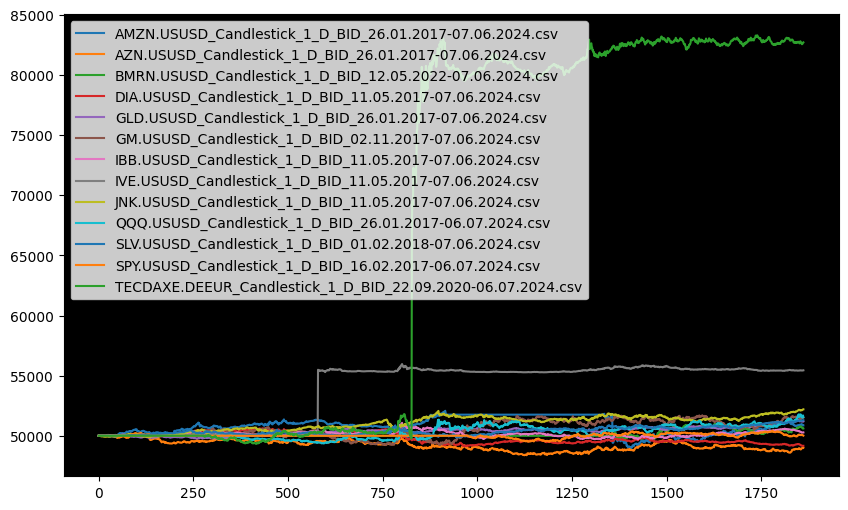

In [17]:
import matplotlib.pyplot as plt

equity_df.plot(kind='line', figsize=(10, 6), legend=True).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('black')
plt.legend(file_names)

In [18]:
[r["Return [%]"] for r in results]

[1.728715007376464,
 -1.991493594096246,
 1.2163731084749307,
 -1.6699444406866968,
 2.3902445039571902,
 3.0149956206756907,
 0.5593842725756695,
 10.884621749139479,
 4.402265587655507,
 3.0959368059111294,
 2.5878287091172822,
 0.03482825690665049,
 65.41127987778464]

In [19]:
file_names

['AMZN.USUSD_Candlestick_1_D_BID_26.01.2017-07.06.2024.csv',
 'AZN.USUSD_Candlestick_1_D_BID_26.01.2017-07.06.2024.csv',
 'BMRN.USUSD_Candlestick_1_D_BID_12.05.2022-07.06.2024.csv',
 'DIA.USUSD_Candlestick_1_D_BID_11.05.2017-07.06.2024.csv',
 'GLD.USUSD_Candlestick_1_D_BID_26.01.2017-07.06.2024.csv',
 'GM.USUSD_Candlestick_1_D_BID_02.11.2017-07.06.2024.csv',
 'IBB.USUSD_Candlestick_1_D_BID_11.05.2017-07.06.2024.csv',
 'IVE.USUSD_Candlestick_1_D_BID_11.05.2017-07.06.2024.csv',
 'JNK.USUSD_Candlestick_1_D_BID_11.05.2017-07.06.2024.csv',
 'QQQ.USUSD_Candlestick_1_D_BID_26.01.2017-06.07.2024.csv',
 'SLV.USUSD_Candlestick_1_D_BID_01.02.2018-07.06.2024.csv',
 'SPY.USUSD_Candlestick_1_D_BID_16.02.2017-06.07.2024.csv',
 'TECDAXE.DEEUR_Candlestick_1_D_BID_22.09.2020-06.07.2024.csv',
 'USO.USUSD_Candlestick_1_D_BID_01.02.2018-07.06.2024.csv']